In [3]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u, constants as const
from mapFunctions import getMap
import os
import random

# --- Select a Random Year ---
year = random.randint(2000, 2024)
print(f"Selected Year: {year}")
months = np.arange(1, 13)

# --- Time array: all days of each month ---
t_daily = []
for m in months:
    # Determine number of days in month (handles leap years via Time)
    t_start = Time(f"{year}-{m:02d}-01T00:00:00", scale='utc')
    t_end = Time(f"{year}-{m%12 + 1:02d}-01T00:00:00", scale='utc') if m < 12 else Time(f"{year+1}-01-01T00:00:00", scale='utc')
    n_days = int((t_end - t_start).value)
    t_daily += [f"{year}-{m:02d}-{d+1:02d}T00:00:00" for d in range(n_days)]

t_array = Time(t_daily, scale='utc')

# --- Get Earth's barycentric velocity (ICRS) for each day ---
_, vel_array = get_body_barycentric_posvel('earth', t_array)

# Split daily velocities into monthly blocks
vx_daily = vel_array.x.to_value(u.km/u.s)
vy_daily = vel_array.y.to_value(u.km/u.s)
vz_daily = vel_array.z.to_value(u.km/u.s)
speed_daily = vel_array.norm().to(u.km/u.s).value

month_day_counts = [len([t for t in t_daily if int(t[5:7]) == m]) for m in months]
idx_split = np.cumsum(month_day_counts)

vx_split = np.split(vx_daily, idx_split[:-1])
vy_split = np.split(vy_daily, idx_split[:-1])
vz_split = np.split(vz_daily, idx_split[:-1])
speed_split = np.split(speed_daily, idx_split[:-1])

# --- CG Amplitude & Phase (Compton-Getting formula) ---
gamma = 2.6
cg_factor = gamma + 2
cg_phases = []
cg_amplitudes = []

for i in range(12):
    vx_mean = np.mean(vx_split[i])
    vy_mean = np.mean(vy_split[i])
    vz_mean = np.mean(vz_split[i])
    v = np.array([vx_mean, vy_mean, vz_mean])
    v_hat = v / np.linalg.norm(v)
    
    # Calculate RA (phase) from unit vector
    x, y, z = v_hat
    ra = np.arctan2(y, x)
    if ra < 0:
        ra += 2 * np.pi
    cg_phases.append(np.degrees(ra))

    # Amplitude calculation
    v_mag = np.mean(speed_split[i])  # average speed for the month
    amp = cg_factor * (v_mag * 1e3 / const.c.value)  # unitless (ratio v/c)
    cg_amplitudes.append(amp)

# --- Load full year map (all months combined) ---
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'

all_data, all_bg, _ = hp.read_map(all_map_file, field=(0, 1, 2))
all_relint = getMap([all_map_file], mapName='relint', smooth=0, verbose=False, mask=True)

# --- Cosine fit model ---
def cos2d(ang, A, phi):
    psi = hp.rotator.angdist(ang, [0.5 * np.pi, phi])
    return A * np.cos(psi)

# --- Fit each month ---
for month in range(1, 13):
    A_CG = cg_amplitudes[month - 1]
    phi_CG = cg_phases[month - 1]
    print(f"[Month {month:02d}] CG: A = {A_CG:.3e}, φ = {phi_CG:.2f}°")

    month_file = monthly_base.format(month)
    if not os.path.isfile(month_file):
        print(f"  Skipping: File not found.")
        continue

    month_data, month_bg, _ = hp.read_map(month_file, field=(0, 1, 2))
    month_relint = getMap([month_file], mapName='relint', smooth=0, verbose=False, mask=True)
    if month_relint is None:
        print(f"  Skipping: Map could not be loaded.")
        continue

    # --- Differential map ---
    diff_map = month_relint - all_relint
    nside = hp.get_nside(diff_map)
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    diff_map_masked = diff_map.copy()
    diff_map_masked[theta < (np.pi/2)] = hp.UNSEEN

    # --- Select field-of-view pixels (90° to 120° from zenith) ---
    fov_pixels = np.where((theta >= np.radians(90)) & (theta <= np.radians(120)))[0]
    fov_angles = hp.pix2ang(nside, fov_pixels)
    fov_values = diff_map[fov_pixels]

    # --- Error propagation ---
    sigma_month = np.sqrt((month_data / month_bg)**2 * (1.0 / month_data + 1.0 / (month_bg * 20)))
    sigma_all   = np.sqrt((all_data / all_bg)**2 * (1.0 / all_data + 1.0 / (all_bg * 20)))
    sigma_fov   = np.sqrt(sigma_month[fov_pixels]**2 + sigma_all[fov_pixels]**2)

    try:
        popt, pcov = curve_fit(
            cos2d, fov_angles, fov_values,
            sigma=sigma_fov,
            bounds=([0, 0], [0.01, 2 * np.pi])
        )
        A_fit, phi_fit = popt
        A_err, phi_err = np.sqrt(np.diag(pcov))
        print(f"  Data Fit: A = {A_fit:.4g} ± {A_err:.1g}, φ = {np.degrees(phi_fit):.2f}° ± {np.degrees(phi_err):.2f}°")
    except Exception as e:
        print(f"  Fit failed: {e}")
        continue



Selected Year: 2012
[Month 01] CG: A = 4.644e-04, φ = 203.06°
  Data Fit: A = 0.000153 ± 9e-06, φ = 201.67° ± 3.22°
[Month 02] CG: A = 4.627e-04, φ = 232.54°
  Data Fit: A = 0.000137 ± 9e-06, φ = 238.24° ± 3.72°
[Month 03] CG: A = 4.595e-04, φ = 264.24°
  Data Fit: A = 0.0001478 ± 9e-06, φ = 269.00° ± 3.36°
[Month 04] CG: A = 4.556e-04, φ = 296.72°
  Data Fit: A = 0.0001312 ± 9e-06, φ = 299.84° ± 3.92°
[Month 05] CG: A = 4.522e-04, φ = 326.92°
  Data Fit: A = 0.0001745 ± 9e-06, φ = 327.30° ± 2.91°
[Month 06] CG: A = 4.501e-04, φ = 354.76°
  Data Fit: A = 0.0001668 ± 9e-06, φ = 355.09° ± 3.06°
[Month 07] CG: A = 4.498e-04, φ = 22.10°
  Data Fit: A = 0.0001677 ± 9e-06, φ = 20.04° ± 3.07°
[Month 08] CG: A = 4.514e-04, φ = 51.62°
  Data Fit: A = 0.0001209 ± 9e-06, φ = 51.27° ± 4.32°
[Month 09] CG: A = 4.545e-04, φ = 83.23°
  Data Fit: A = 0.0001714 ± 9e-06, φ = 78.28° ± 3.03°
[Month 10] CG: A = 4.583e-04, φ = 115.69°
  Data Fit: A = 0.0001565 ± 8e-06, φ = 116.78° ± 3.06°
[Month 11] CG: A =

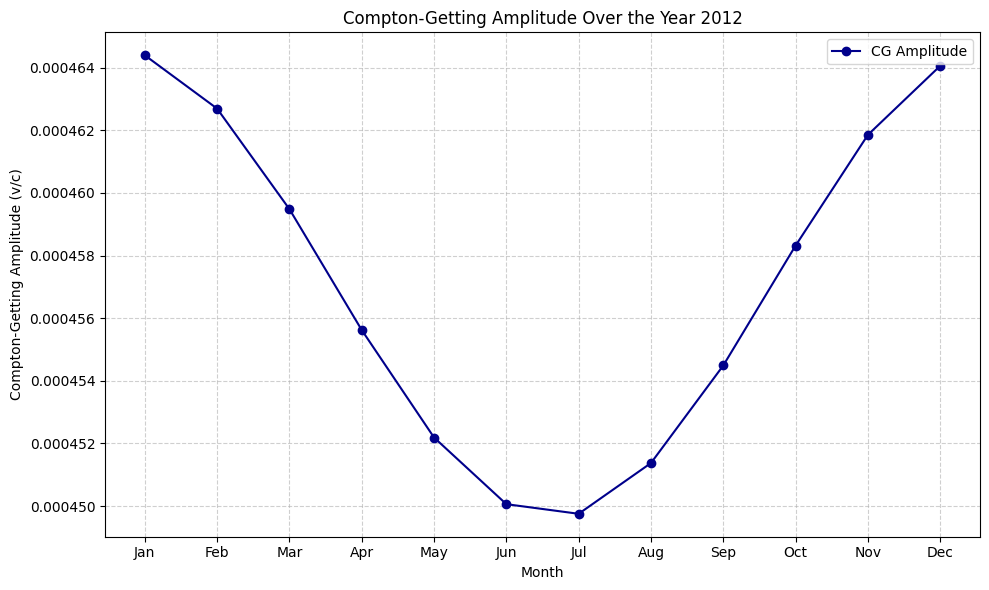

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- Sample data (replace with actual list if running independently) ---
# cg_amplitudes = [ ... ]  # <-- this should be defined in the main script

# --- Months for x-axis ---
months = np.arange(1, 13)
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(months, cg_amplitudes, marker='o', linestyle='-', color='darkblue', label='CG Amplitude')

plt.xticks(months, month_labels)
plt.xlabel("Month")
plt.ylabel("Compton-Getting Amplitude (v/c)")
plt.title(f"Compton-Getting Amplitude Over the Year {year}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()


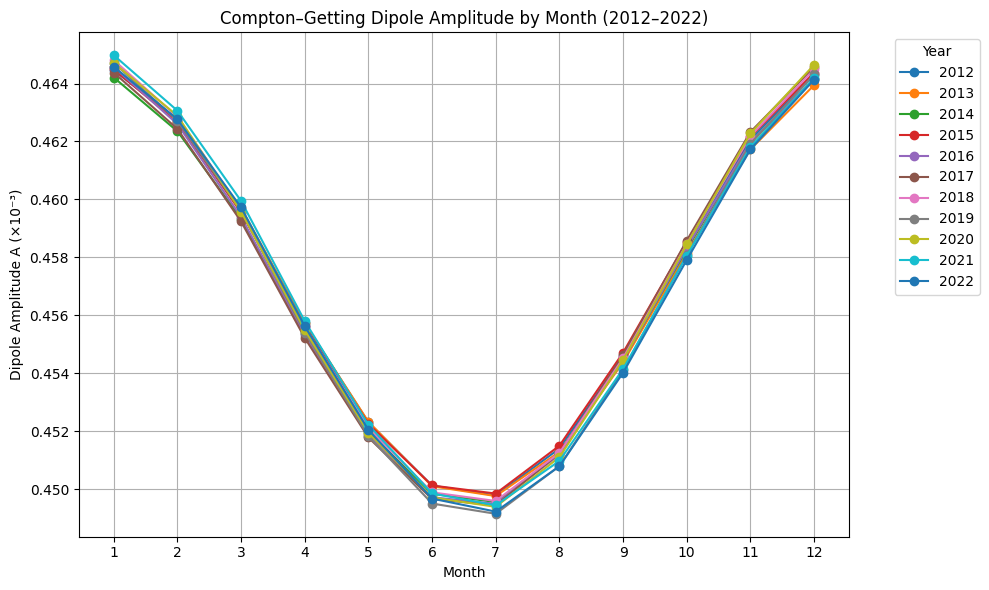

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# Settings
gamma = 2.6
cg_factor = gamma + 2
year_range = range(2012, 2023)
months = np.arange(1, 13)

plt.figure(figsize=(10, 6))  # Create one figure for all years

for year in year_range:
    # Time array for 15th of each month
    t_list = [f"{year}-{month:02d}-15T00:00:00" for month in months]
    t_array = Time(t_list, scale='utc')

    # Get Earth's barycentric velocity
    _, vel = get_body_barycentric_posvel('earth', t_array)
    speed = vel.norm().to('m/s').value

    # Compute dipole amplitude
    A_CG = cg_factor * (speed / const.c.value)

    # Plot for this year
    plt.plot(months, A_CG * 1e3, marker='o', label=str(year))

# Finalize plot
plt.xticks(months)
plt.xlabel("Month")
plt.ylabel("Dipole Amplitude A (×10⁻³)")
plt.title("Compton–Getting Dipole Amplitude by Month (2012–2022)")
plt.grid(True)
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


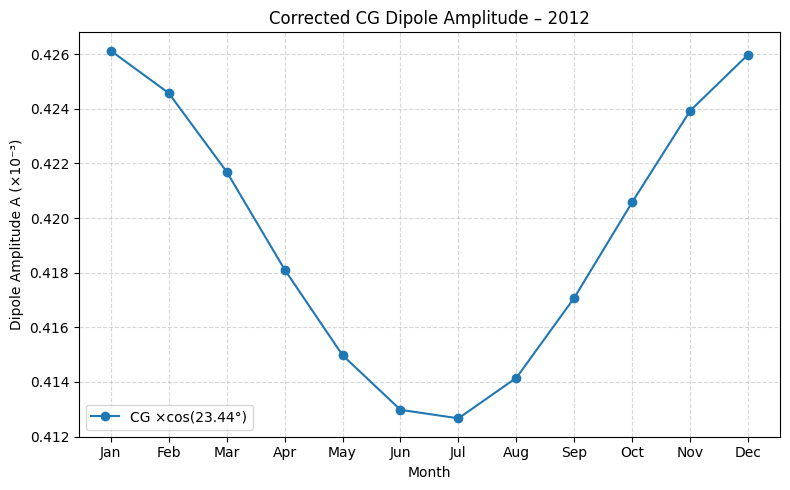

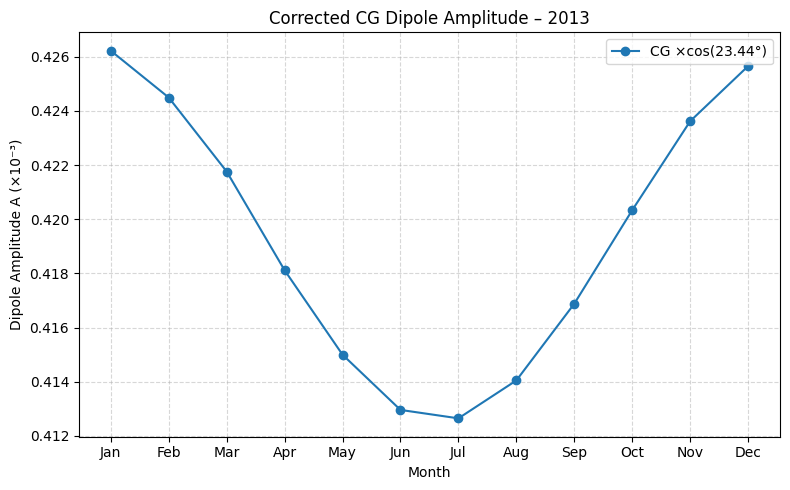

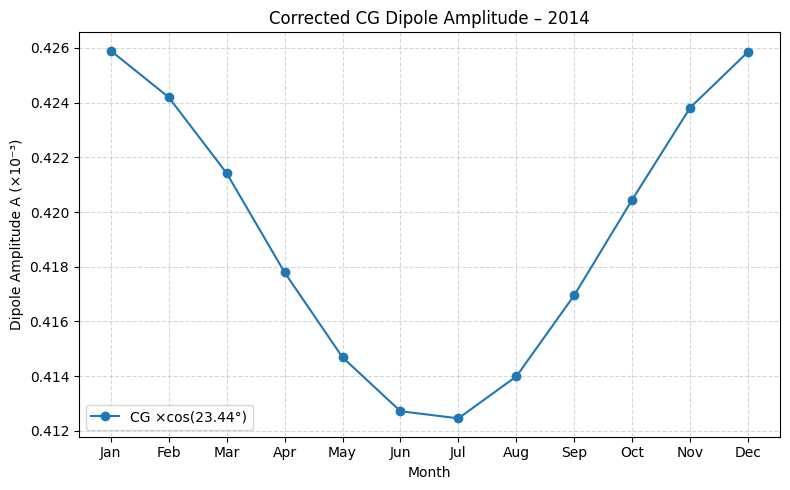

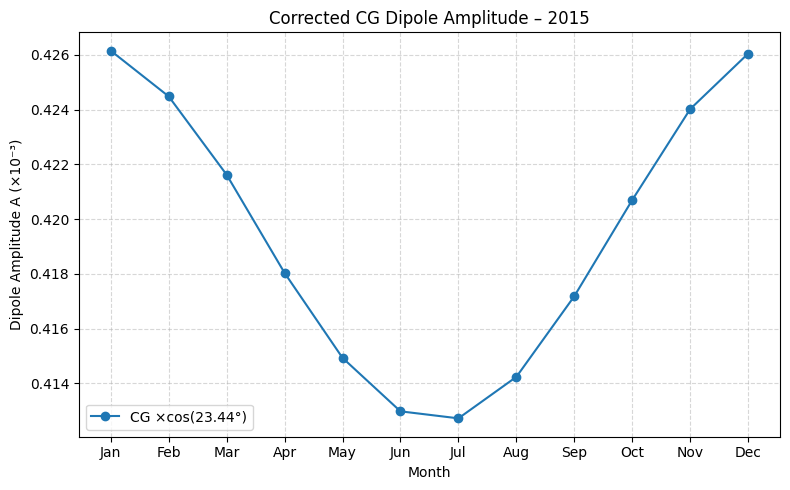

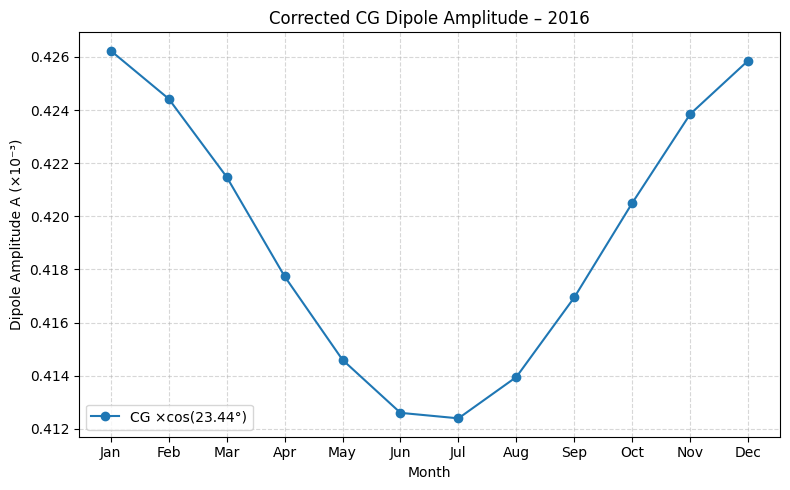

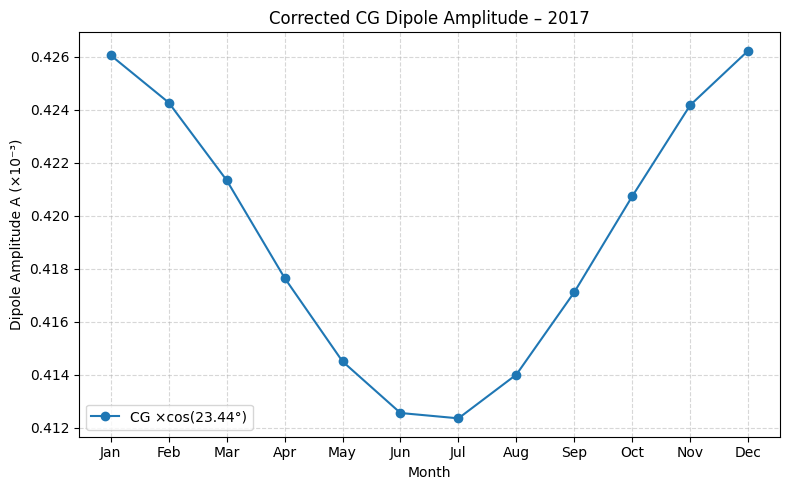

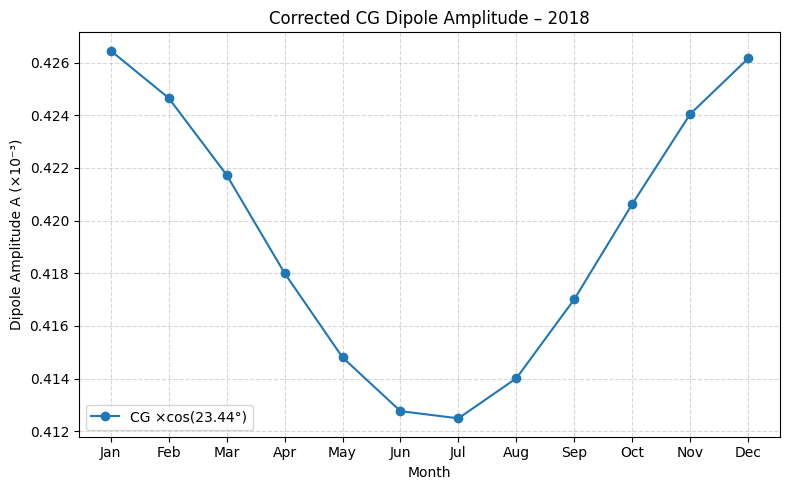

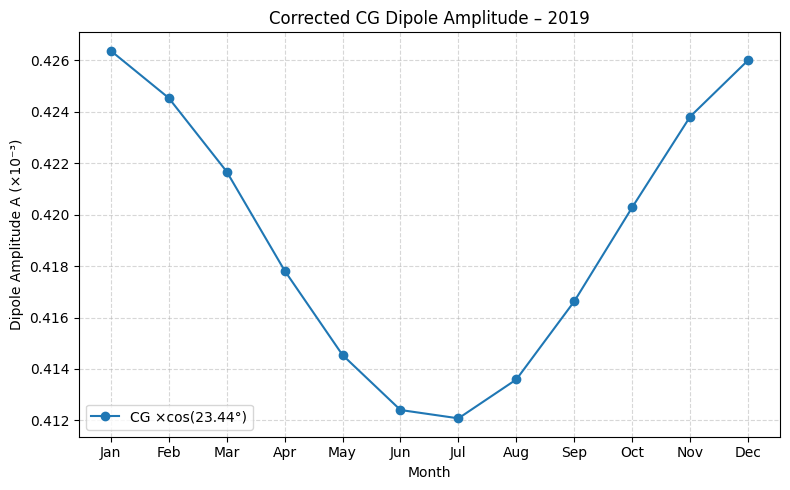

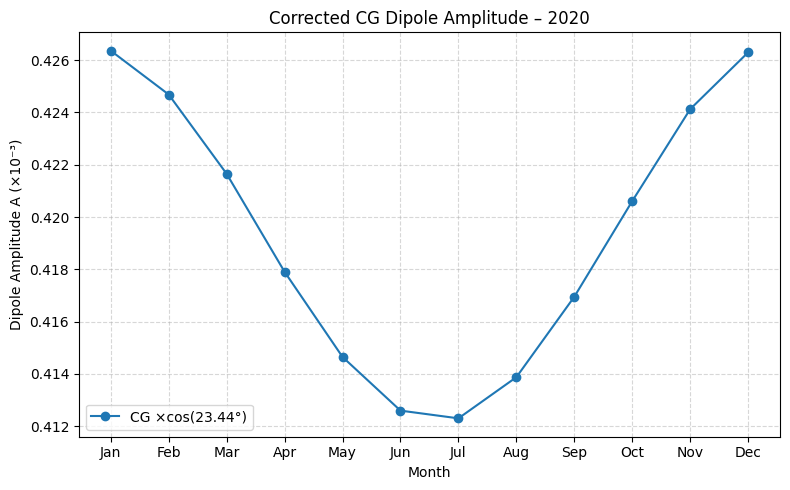

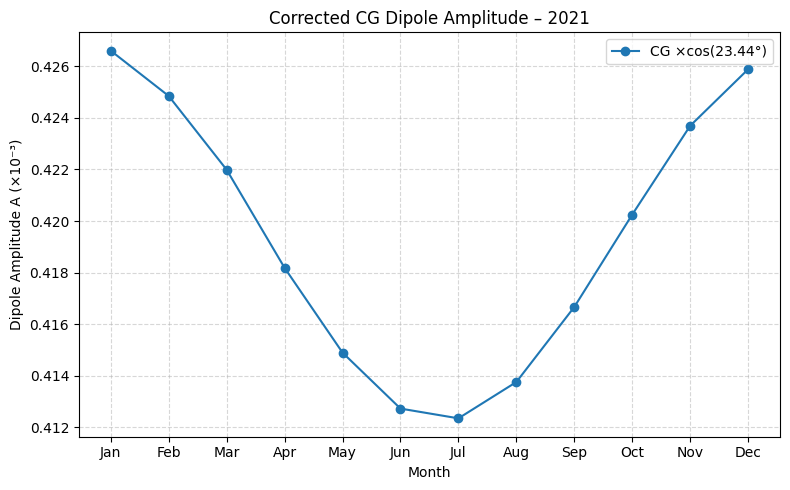

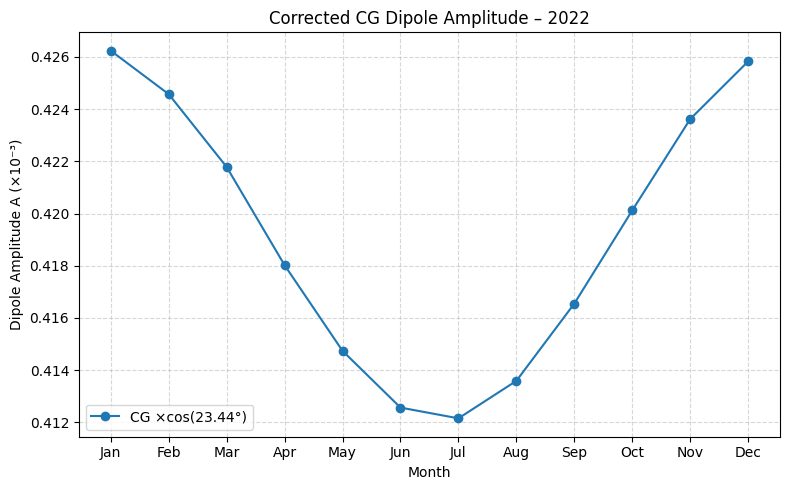

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# --- Settings ---
gamma    = 2.6
cg_factor = gamma + 2

tilt_deg = 23.44
cos_tilt = np.cos(np.radians(tilt_deg))

years  = np.arange(2012, 2023)
months = np.arange(1, 13)

# --- Loop over years ---
for year in years:
    # build time array for the 15th of each month
    t_list = [f"{year}-{m:02d}-15T00:00:00" for m in months]
    t_arr  = Time(t_list, scale='utc')

    # get Earth's barycentric velocity
    _, vel = get_body_barycentric_posvel('earth', t_arr)
    speeds_ms = vel.norm().to('m/s').value  # shape (12,)

    # compute raw CG amplitude
    A_CG = cg_factor * (speeds_ms / const.c.value)

    # apply tilt correction
    A_CG_corr = A_CG * cos_tilt

    # plot in units of ×10⁻³ for readability
    plt.figure(figsize=(8,5))
    plt.plot(months, A_CG_corr * 1e3, 'o-', label=f'CG ×cos({tilt_deg}°)')
    plt.xticks(months, ['Jan','Feb','Mar','Apr','May','Jun',
                        'Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.xlabel('Month')
    plt.ylabel('Dipole Amplitude A (×10⁻³)')
    plt.title(f'Corrected CG Dipole Amplitude – {year}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


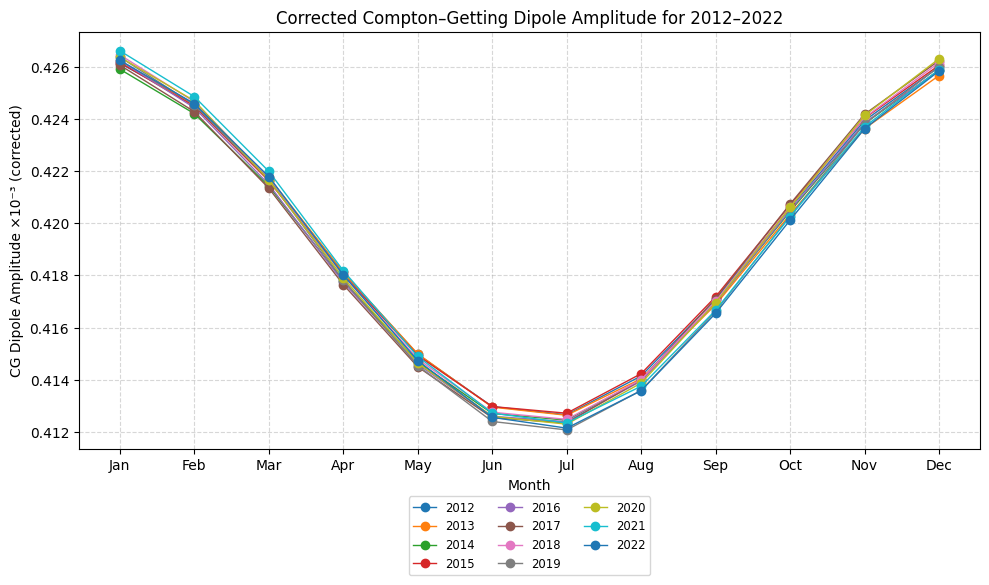

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# --- Settings ---
gamma     = 2.6
cg_factor = gamma + 2

tilt_deg  = 23.44
cos_tilt  = np.cos(np.radians(tilt_deg))

years  = np.arange(2012, 2023)
months = np.arange(1, 13)

# Pre‐allocate array: rows=years, cols=months
all_corr = np.zeros((len(years), len(months)))

# Compute corrected CG amplitude for each year/month
for i, year in enumerate(years):
    # mid‑month times
    t_list = [f"{year}-{m:02d}-15T00:00:00" for m in months]
    t_arr  = Time(t_list, scale='utc')

    # Earth's barycentric velocity
    _, vel = get_body_barycentric_posvel('earth', t_arr)
    speeds_ms = vel.norm().to('m/s').value  # shape (12,)

    # CG amplitude and tilt correction
    A_CG       = cg_factor * (speeds_ms / const.c.value)
    A_CG_corr  = A_CG * cos_tilt

    # store in ×10⁻³ units
    all_corr[i, :] = A_CG_corr * 1e3

# Plot all years on one figure
plt.figure(figsize=(10, 6))

# month labels
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

for i, year in enumerate(years):
    plt.plot(months,
             all_corr[i],
             marker='o',
             label=str(year),
             linewidth=1)

plt.xticks(months, month_names)
plt.xlabel('Month')
plt.ylabel('CG Dipole Amplitude ×10⁻³ (corrected)')
plt.title('Corrected Compton–Getting Dipole Amplitude for 2012–2022')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(ncol=3, fontsize='small', loc='upper center',
           bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

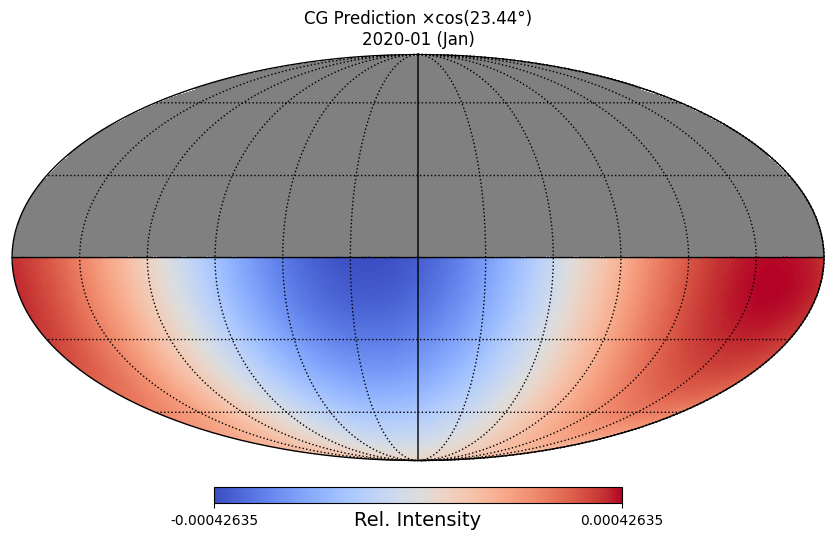

<Figure size 600x400 with 0 Axes>

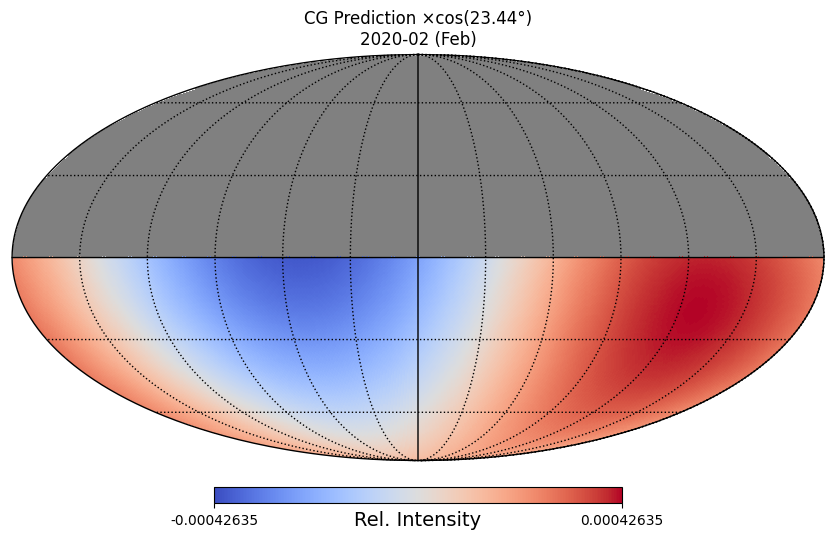

<Figure size 600x400 with 0 Axes>

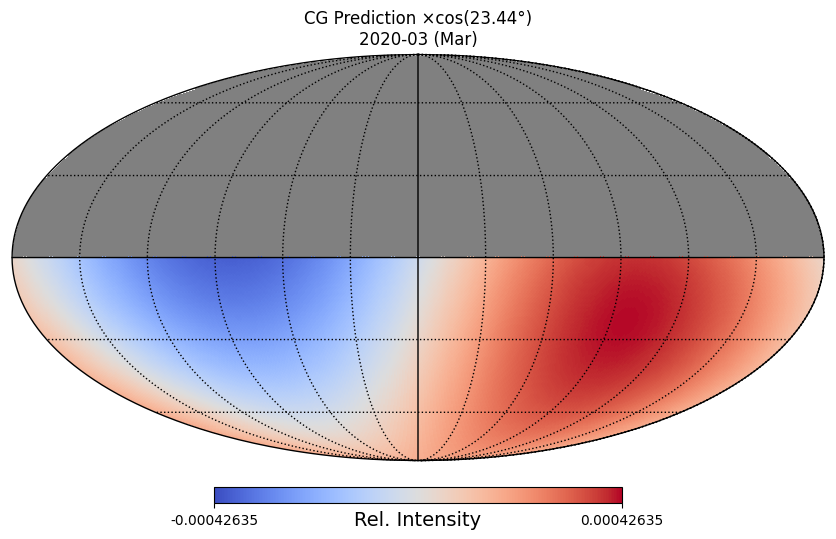

<Figure size 600x400 with 0 Axes>

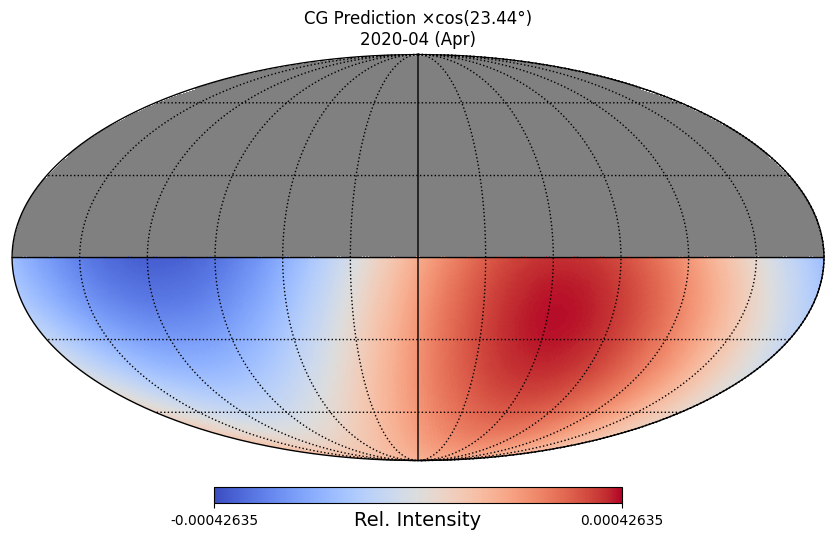

<Figure size 600x400 with 0 Axes>

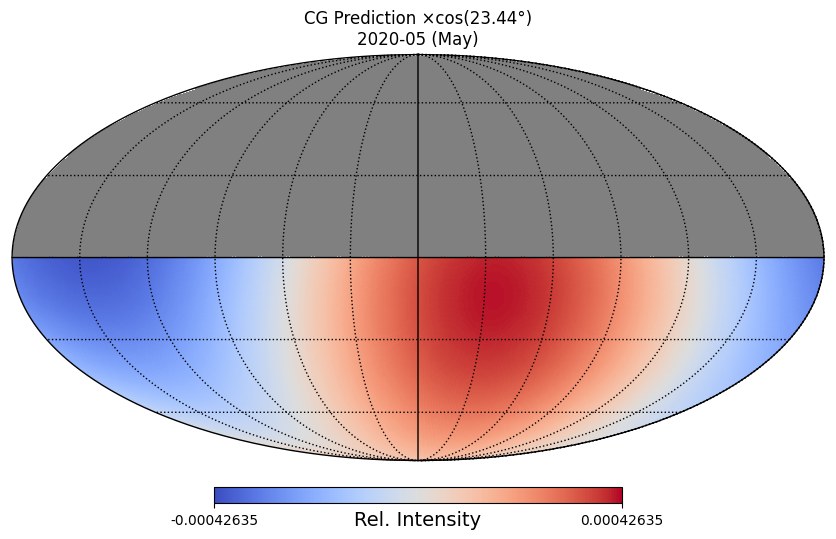

<Figure size 600x400 with 0 Axes>

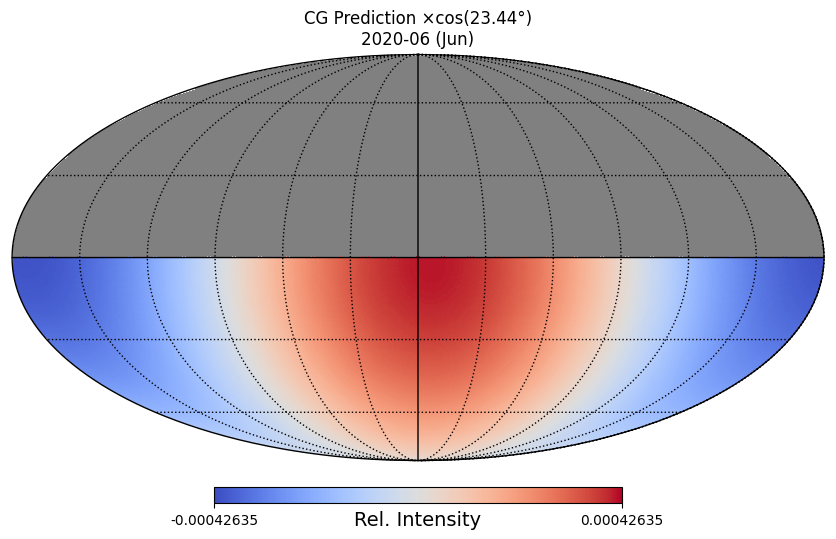

<Figure size 600x400 with 0 Axes>

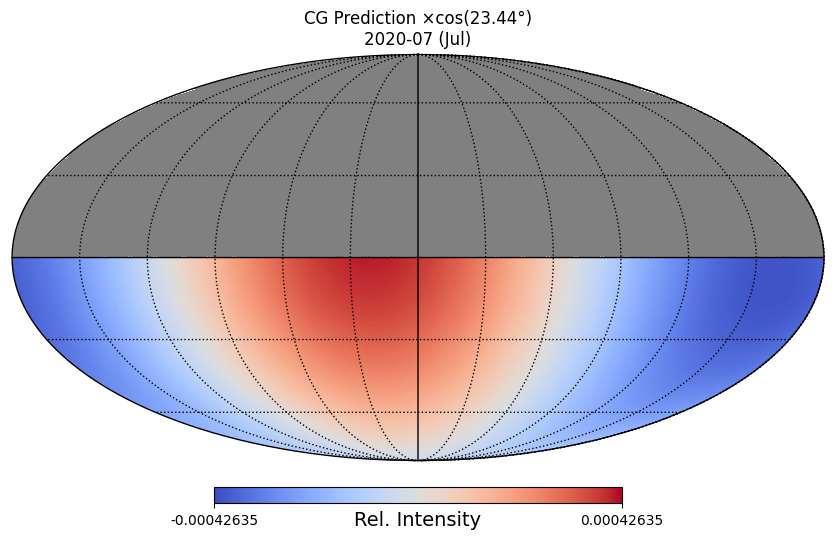

<Figure size 600x400 with 0 Axes>

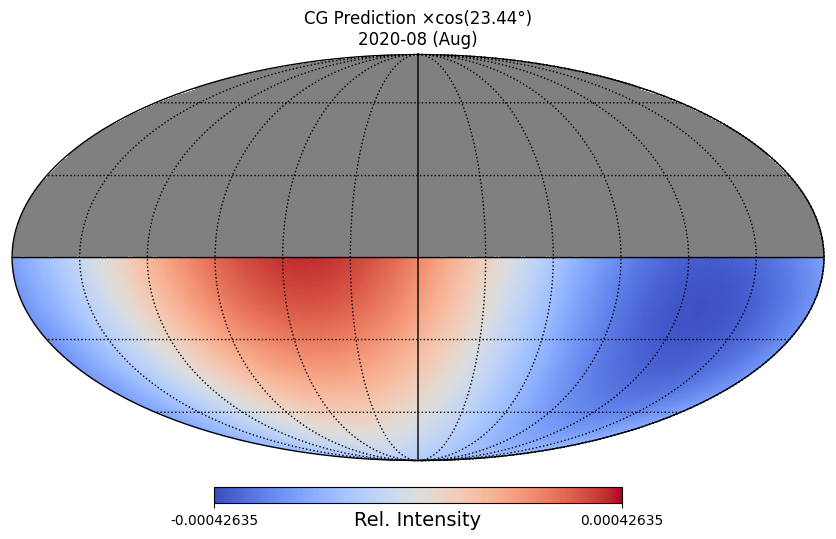

<Figure size 600x400 with 0 Axes>

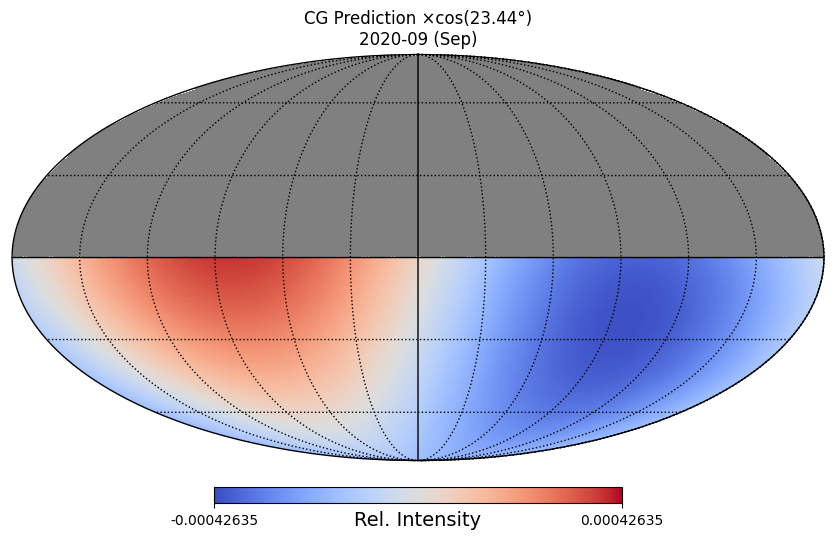

<Figure size 600x400 with 0 Axes>

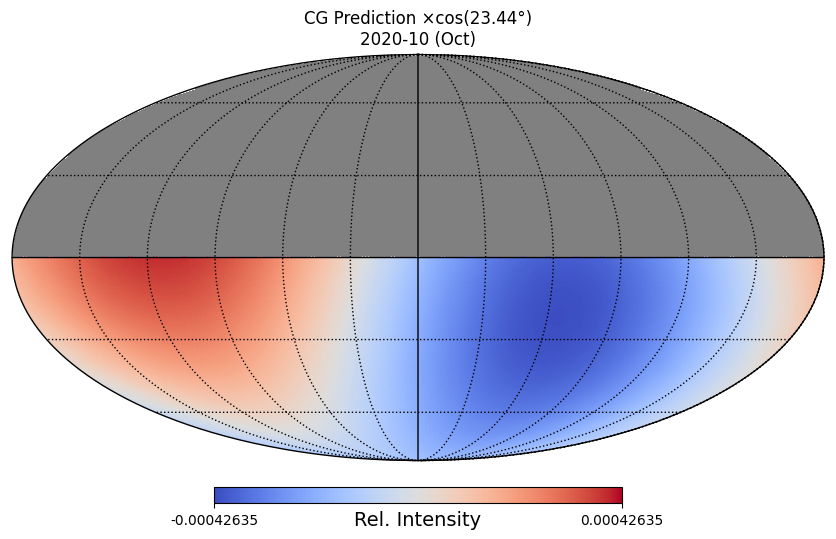

<Figure size 600x400 with 0 Axes>

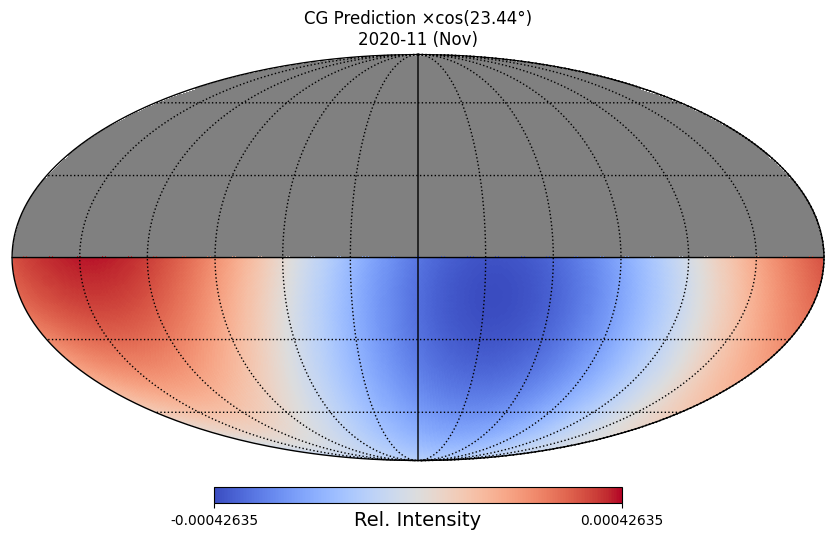

<Figure size 600x400 with 0 Axes>

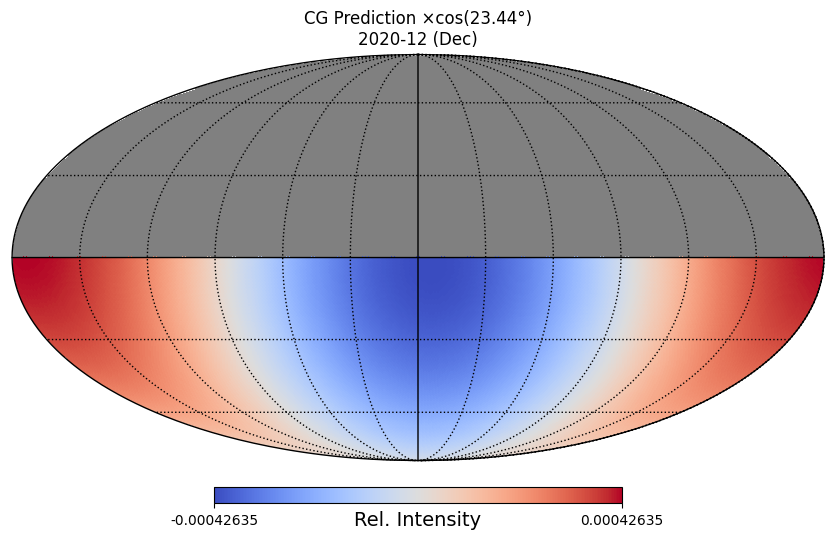

In [27]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# SETTINGS
year      = 2020
months    = np.arange(1, 13)
gamma     = 2.6
cg_factor = gamma + 2
tilt_deg  = 23.44
cos_tilt  = np.cos(np.radians(tilt_deg))

# Healpix resolution
nside = 64
npix  = hp.nside2npix(nside)
pixs  = np.arange(npix)

# Get theta, phi for all pixels
theta, phi = hp.pix2ang(nside, pixs)

# Define Northern Hemisphere Mask
north_mask = theta < (np.pi / 2)  # θ < 90°

# IceCube FoV: Decl. -30° to -90° ⇒ θ = 90°–120°
fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))
fov_pixels = np.where(fov_mask)[0]  # these are the pixels in the FoV

# 1) Compute CG maps with masking
cg_maps = []
fov_values_by_month = []

for month in months:
    t = Time(f"{year}-{month:02d}-15T00:00:00", scale='utc')
    _, vel = get_body_barycentric_posvel('earth', t)
    vvec = np.array([vel.x.to('m/s').value,
                     vel.y.to('m/s').value,
                     vel.z.to('m/s').value])
    vhat = vvec / np.linalg.norm(vvec)
    A_CG = cg_factor * (np.linalg.norm(vvec) / const.c.value)

    # Compute dipole
    vecs = hp.pix2vec(nside, pixs)
    dots = np.dot(vhat, vecs)
    dipole = A_CG * dots * cos_tilt

    # Apply northern hemisphere mask
    dipole_masked = dipole.copy()
    dipole_masked[north_mask] = hp.UNSEEN

    # Store masked map
    cg_maps.append(dipole_masked)

    # Extract FoV values for this month (not masked)
    fov_values = dipole[fov_pixels]
    fov_values_by_month.append(fov_values)

cg_maps = np.array(cg_maps)
fov_values_by_month = np.array(fov_values_by_month)  # shape (12, N_pixels_in_fov)

# 2) Determine color scale from only FoV values
all_fov_vals = np.hstack(fov_values_by_month)
vlim = np.max(np.abs(all_fov_vals))
vmin, vmax = -vlim, vlim

# Month names
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

# 3) Plot CG dipole maps with northern hemisphere masked
for idx, month in enumerate(months):
    plt.figure(figsize=(6, 4))
    hp.mollview(
        cg_maps[idx],
        title=f'CG Prediction ×cos({tilt_deg}°)\n{year}-{month:02d} ({month_names[idx]})',
        unit='Rel. Intensity',
        cmap='coolwarm',
        min=vmin,
        max=vmax,
        notext=True
    )
    hp.graticule()
    plt.show()


In [5]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const
import os
from mapFunctions import getMap

# --- Paths ---
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'
output_dir = 'residual_maps'  # Folder to save figures
os.makedirs(output_dir, exist_ok=True)

# --- Settings ---
year = 2020
months = np.arange(1, 13)
gamma = 2.6
cg_factor = gamma + 2
tilt_deg = 23.44
cos_tilt = np.cos(np.radians(tilt_deg))

# Load 12-year average relative intensity map
if not os.path.isfile(all_map_file):
    raise FileNotFoundError(f"All-data map not found: {all_map_file}")

all_relint = getMap([all_map_file], mapName='relint', smooth=20, verbose=False, mask=True)

# Prepare Healpix info
nside = hp.get_nside(all_relint)
npix = hp.nside2npix(nside)
pixs = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixs)

# Southern hemisphere mask (theta >= 90 deg)
south_mask = theta >= (np.pi / 2)

# Loop over each month
for month in months:
    month_file = monthly_base.format(month)
    if not os.path.isfile(month_file):
        print(f"Skipping month {month:02d}: file not found")
        continue

    try:
        month_relint = getMap([month_file], mapName='relint', smooth=20, verbose=False, mask=True)
    except Exception as e:
        print(f"Error loading month {month:02d}: {e}")
        continue

    if month_relint is None or all_relint is None:
        print(f"Skipping month {month:02d}: map could not be loaded.")
        continue

    # Compute monthly difference map: data - average
    diff_map = month_relint - all_relint

    # --- Compute CG dipole prediction for this month ---
    t = Time(f"{year}-{month:02d}-15T00:00:00", scale='utc')
    _, vel = get_body_barycentric_posvel('earth', t)
    vvec = np.array([vel.x.to('m/s').value,
                     vel.y.to('m/s').value,
                     vel.z.to('m/s').value])
    vhat = vvec / np.linalg.norm(vvec)
    A_CG = cg_factor * (np.linalg.norm(vvec) / const.c.value)

    vecs = hp.pix2vec(nside, pixs)
    dots = np.dot(vhat, vecs)
    cg_map = A_CG * dots * cos_tilt

    # Calculate residual: difference map minus CG dipole map
    residual_map = diff_map - cg_map

    # Mask northern hemisphere
    residual_map_masked = residual_map.copy()
    residual_map_masked[theta < (np.pi / 2)] = hp.UNSEEN
    # Create a mask for valid pixels (both maps are not UNSEEN)
    valid_mask = (month_relint != hp.UNSEEN) & (all_relint != hp.UNSEEN)

    # Southern hemisphere mask
    south_mask = theta >= (np.pi / 2)

    # Combined mask: only southern sky and valid pixels
    final_mask = valid_mask & south_mask

    # Apply mask: everything else set to UNSEEN
    residual_map_masked = np.full_like(residual_map, hp.UNSEEN)
    residual_map_masked[final_mask] = residual_map[final_mask]

    
    # Plot and save residual map
    plt.figure(figsize=(7, 5))
    hp.mollview(
        residual_map_masked,
        title=f'Residual Map (Data − CG Dipole), Month {month:02d}',
        unit='Rel. Intensity',
        cmap='coolwarm',
        min=-0.001,
        max=0.001,
        notext=True,
        badcolor='lightgrey'
    )
    hp.graticule()
    output_path = os.path.join(output_dir, f"residual_map_month_{month:02d}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

Month 01: Predicted A=4.646e-04, Measured A=1.530e-04
Month 02: Predicted A=4.627e-04, Measured A=1.370e-04
Month 03: Predicted A=4.596e-04, Measured A=1.478e-04
Month 04: Predicted A=4.555e-04, Measured A=1.312e-04
Month 05: Predicted A=4.521e-04, Measured A=1.745e-04
Month 06: Predicted A=4.498e-04, Measured A=1.668e-04
Month 07: Predicted A=4.495e-04, Measured A=1.677e-04
Month 08: Predicted A=4.512e-04, Measured A=1.209e-04
Month 09: Predicted A=4.544e-04, Measured A=1.714e-04
Month 10: Predicted A=4.583e-04, Measured A=1.565e-04
Month 11: Predicted A=4.620e-04, Measured A=1.578e-04
Month 12: Predicted A=4.643e-04, Measured A=1.531e-04


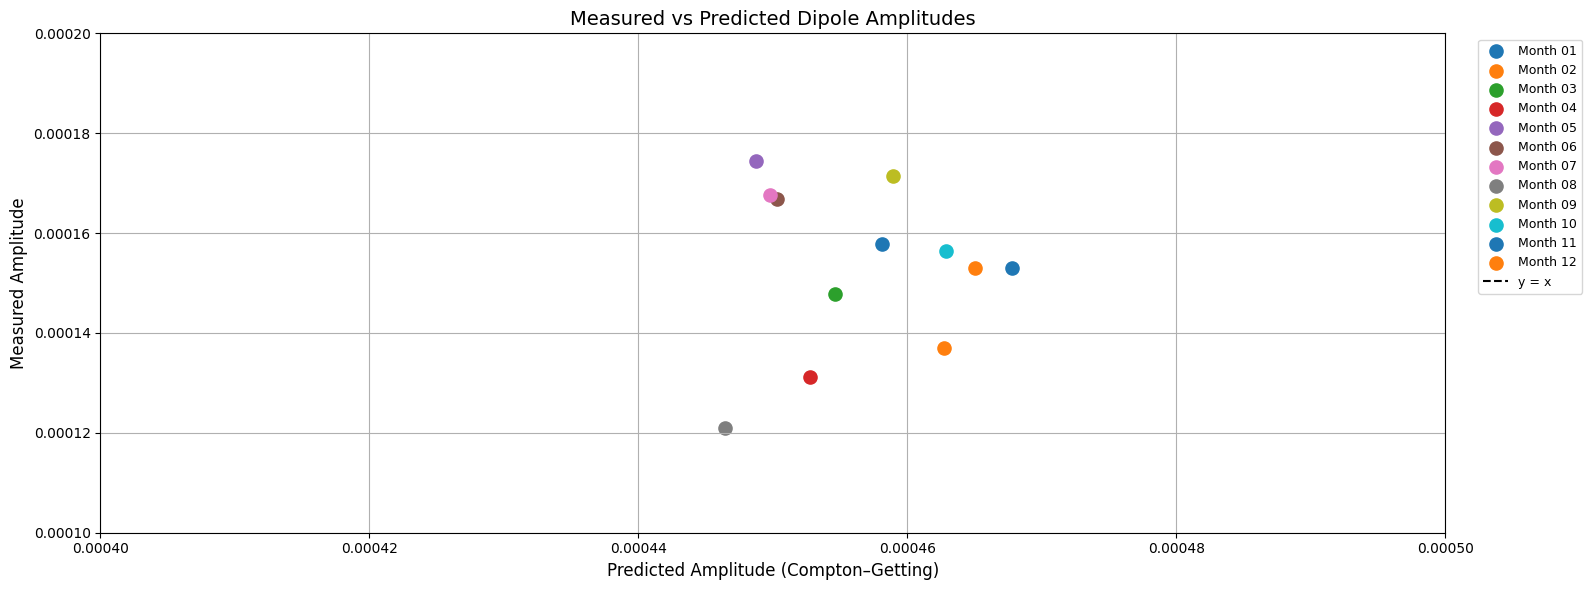

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import units as u, constants as const
from mapFunctions import getMap
import os
import random

# Time and CG setup
years = np.arange(2012, 2023)
months = np.arange(1, 13)
t_list = [f"{y:04d}-{m:02d}-15T00:00:00" for y in years for m in months]
t_array = Time(t_list, scale='utc')
_, vel_array = get_body_barycentric_posvel('earth', t_array)
speed_array = vel_array.norm().to(u.km/u.s).value
speed_mat = speed_array.reshape(len(years), 12)
mean_speed_per_month = speed_mat.mean(axis=0)
gamma = 2.6
cg_factor = gamma + 2

# Paths
monthly_base = '/data/user/fmcnally/anisotropy/maps/merged_monthly/IC86_N10_sid_{:02d}.fits'
all_map_file = '/data/user/fmcnally/anisotropy/maps/merged/IC86_N10_sid.fits'

# Dipole model
def cos2d(ang, A, phi):
    psi = hp.rotator.angdist(ang, [0.5 * np.pi, phi])
    return A * np.cos(psi)

# Load full-year reference map
all_data, all_bg, _ = hp.read_map(all_map_file, field=(0, 1, 2))
all_relint = getMap([all_map_file], mapName='relint', smooth=0, verbose=False, mask=True)

# Store values
predicted_amps = []
measured_amps = []
month_labels = []

# Loop through each month
for month in range(1, 13):
    A_CG = cg_factor * (mean_speed_per_month[month - 1] * 1e3 / const.c.value)
    month_file = monthly_base.format(month)
    
    if not os.path.isfile(month_file):
        print(f"Skipping month {month:02d}: file not found")
        continue
    month_data, month_bg, _ = hp.read_map(month_file, field=(0, 1, 2))
    month_relint = getMap([month_file], mapName='relint', smooth=0, verbose=False, mask=True)
    if month_relint is None:
        print(f"Skipping month {month:02d}: map could not be loaded")
        continue

    diff_map = month_relint - all_relint
    nside = hp.get_nside(diff_map)
    theta, phi = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    fov_pixels = np.where((theta >= np.radians(90)) & (theta <= np.radians(120)))[0]
    fov_angles = hp.pix2ang(nside, fov_pixels)
    fov_values = diff_map[fov_pixels]

    sigma_month = np.sqrt((month_data/month_bg)**2 * (1.0/month_data + 1.0/(month_bg*20)))
    sigma_all = np.sqrt((all_data/all_bg)**2 * (1.0/all_data + 1.0/(all_bg*20)))
    sigma_fov = np.sqrt(sigma_month[fov_pixels]**2 + sigma_all[fov_pixels]**2)

    try:
        popt, _ = curve_fit(cos2d, fov_angles, fov_values, sigma=sigma_fov,
                            bounds=([0, 0], [0.01, 2*np.pi]))
        A_fit = popt[0]
        predicted_amps.append(A_CG)
        measured_amps.append(A_fit)
        month_labels.append(month)
        print(f"Month {month:02d}: Predicted A={A_CG:.3e}, Measured A={A_fit:.3e}")
    except Exception as e:
        print(f"Fit failed for month {month:02d}: {e}")
        continue

# Convert to arrays
predicted_amps = np.array(predicted_amps)
measured_amps = np.array(measured_amps)
month_labels = np.array(month_labels)

# Plotting
plt.figure(figsize=(16, 6))  # Wide figure for clarity
cmap = plt.get_cmap('tab10')
num_points = len(predicted_amps)

for i in range(num_points):
    color = cmap(i % 10)
    jitter = (random.random() - 0.5) * 1e-5  # small horizontal jitter
    plt.scatter(predicted_amps[i] + jitter, measured_amps[i], color=color, s=90, label=f"Month {month_labels[i]:02d}")

min_val = min(predicted_amps.min(), measured_amps.min()) * 0.95
max_val = max(predicted_amps.max(), measured_amps.max()) * 1.05
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

plt.xlabel("Predicted Amplitude (Compton–Getting)", fontsize=12)
plt.ylabel("Measured Amplitude", fontsize=12)
plt.title("Measured vs Predicted Dipole Amplitudes", fontsize=14)
plt.grid(True)
plt.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()

plt.xlim(0.00040, 0.00050)
plt.ylim(0.00010, 0.00020)
plt.savefig("measured_vs_predicted_dipole_amplitudes.png", dpi=300)

plt.show()

[Month 01] A_CG = 4.1439e-04 ± 3.1e-06, Phase = 157.85°


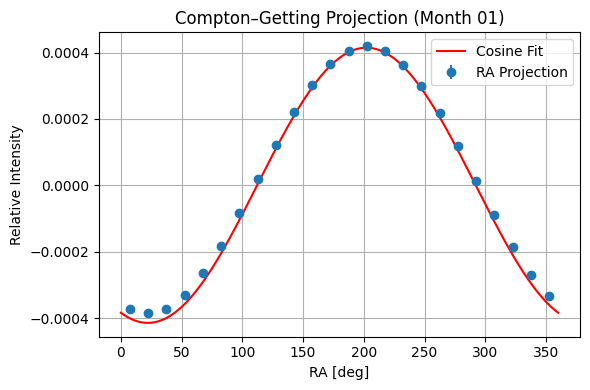

[Month 02] A_CG = 4.1293e-04 ± 5.1e-06, Phase = 127.44°


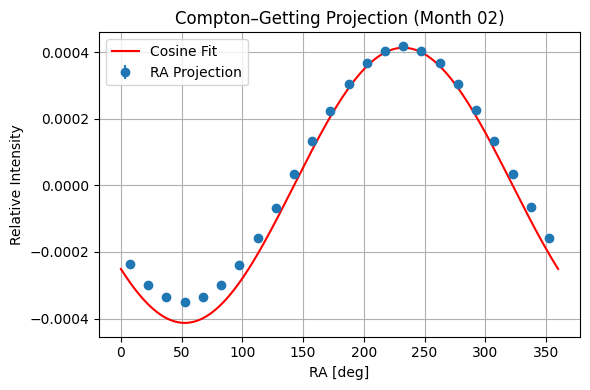

[Month 03] A_CG = 4.0249e-04 ± 7.6e-06, Phase = 96.82°


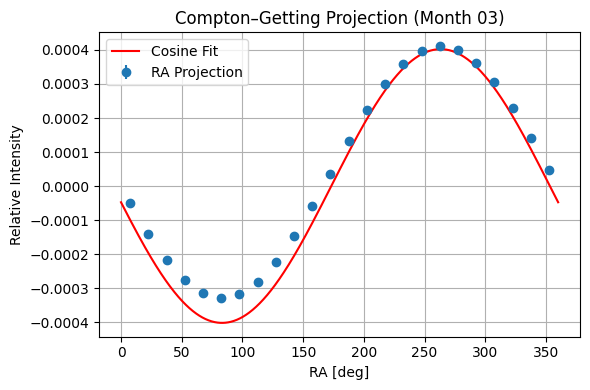

[Month 04] A_CG = 4.0284e-04 ± 6.4e-06, Phase = 63.77°


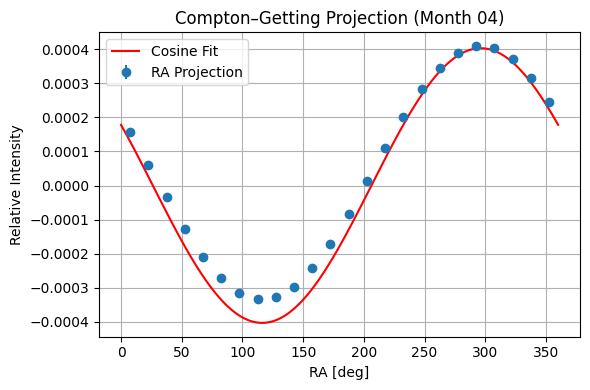

[Month 05] A_CG = 4.0609e-04 ± 3.3e-06, Phase = 33.99°


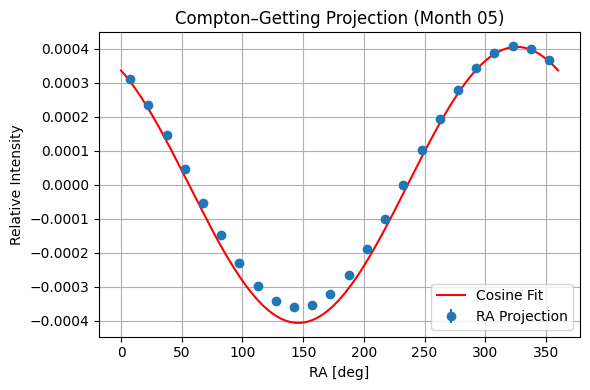

[Month 06] A_CG = 3.9481e-04 ± 1.1e-06, Phase = 5.64°


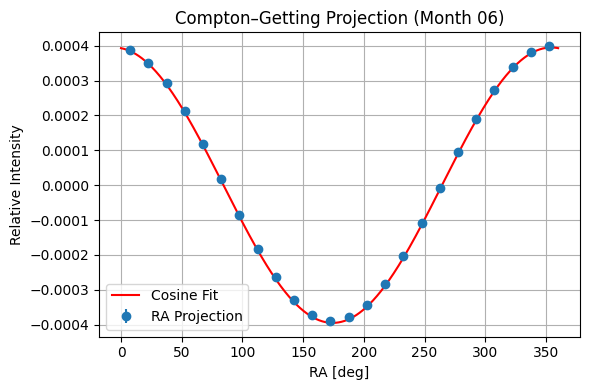

[Month 07] A_CG = 4.0035e-04 ± 3.0e-06, Phase = 338.75°


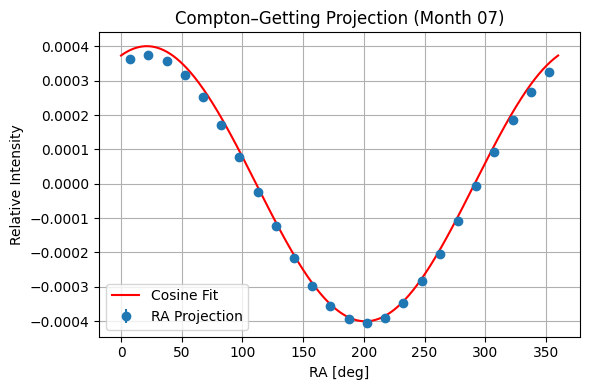

[Month 08] A_CG = 4.0296e-04 ± 4.8e-06, Phase = 309.32°


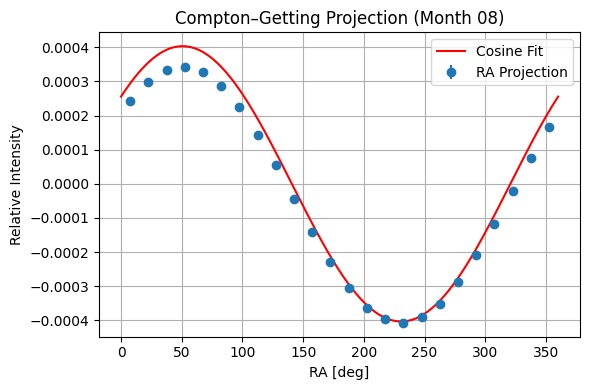

[Month 09] A_CG = 3.9804e-04 ± 7.5e-06, Phase = 277.24°


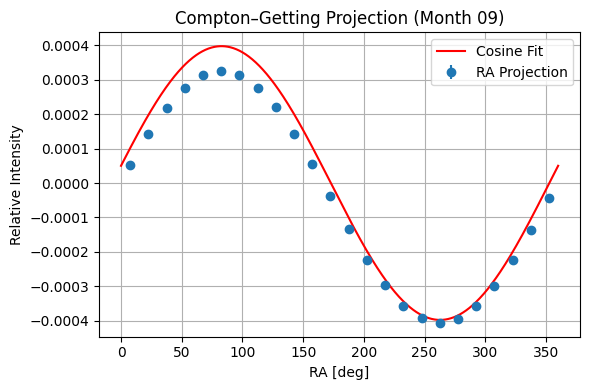

[Month 10] A_CG = 4.0500e-04 ± 6.5e-06, Phase = 245.30°


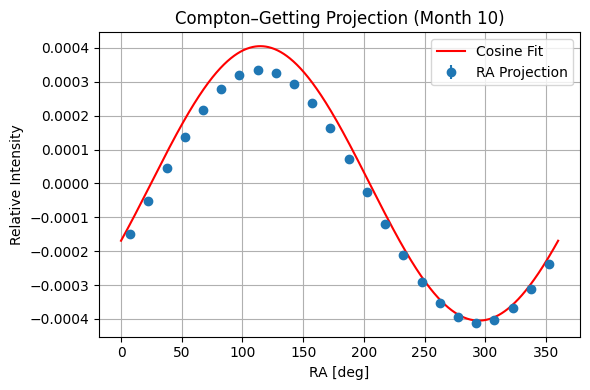

[Month 11] A_CG = 4.1538e-04 ± 3.3e-06, Phase = 214.02°


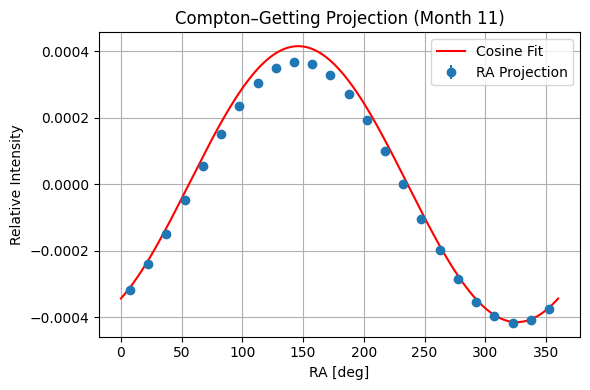

[Month 12] A_CG = 4.0796e-04 ± 1.2e-06, Phase = 185.83°


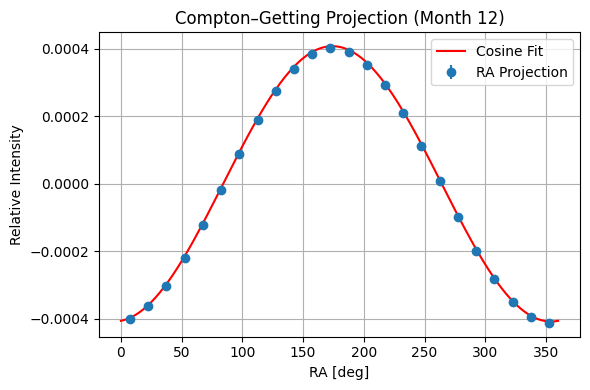

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.time import Time
from astropy.coordinates import get_body_barycentric_posvel
from astropy import constants as const

# --- Settings ---
gamma = 2.6
cg_factor = gamma + 2
tilt_deg = 23.44
cos_tilt = np.cos(np.radians(tilt_deg))
months = np.arange(1, 13)
year = 2020

# HEALPix map setup
nside = 64
npix = hp.nside2npix(nside)
pixs = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixs)

# IceCube southern sky FoV (declination -30° to -90° ⇒ θ = 90°–120°)
fov_mask = (theta >= np.radians(90)) & (theta <= np.radians(120))

# --- Cosine function for dipole fitting ---
def acos_func(x, A, phi):
    return A * np.cos(np.radians(x) + phi)

# --- ReturnRI: RA projection of dipole map ---
def returnRI(relint_map, relerr_map, **opts):
    degree = np.pi / 180
    ramin = opts['ramin'] * degree
    ramax = opts['ramax'] * degree
    rabins = np.linspace(ramin, ramax, opts['nbins'] + 1)

    theta, phi = hp.pix2ang(hp.npix2nside(len(relint_map)), np.arange(len(relint_map)))
    phiBins = np.digitize(phi, rabins) - 1
    cut = (relint_map != hp.UNSEEN)

    ri, sigmay = np.zeros((2, opts['nbins']))
    for i in range(opts['nbins']):
        c0 = cut * (phiBins == i)
        if np.sum(c0) > 0:
            ri[i] = np.mean(relint_map[c0])
            sigmay[i] = np.std(relint_map[c0]) / np.sqrt(np.sum(c0))
        else:
            ri[i] = np.nan
            sigmay[i] = np.nan

    dx = (ramax - ramin) / (2 * opts['nbins'])
    ra = np.linspace(ramin + dx, ramax - dx, opts['nbins']) / degree
    sigmax = dx * np.ones(opts['nbins']) / degree

    return ra, ri, sigmax, sigmay

# --- Storage ---
cg_amplitudes = []
cg_errors = []
cg_phases = []

# --- Loop over months ---
opts = {'ramin': 0, 'ramax': 360, 'nbins': 24}

for month in months:
    # Get orbital velocity
    t = Time(f"{year}-{month:02d}-15T00:00:00", scale='utc')
    _, vel = get_body_barycentric_posvel('earth', t)
    vvec = np.array([vel.x.to('m/s').value, vel.y.to('m/s').value, vel.z.to('m/s').value])
    vhat = vvec / np.linalg.norm(vvec)
    A_CG = cg_factor * (np.linalg.norm(vvec) / const.c.value)

    # Make CG dipole map
    vecs = hp.pix2vec(nside, pixs)
    dots = np.dot(vhat, vecs)
    dipole = A_CG * dots * cos_tilt

    # Mask for IceCube southern sky
    dipole_masked = np.full(npix, hp.UNSEEN)
    dipole_masked[fov_mask] = dipole[fov_mask]

    # Dummy error map
    dummy_err = np.full(npix, 1e-5)
    dummy_err[~fov_mask] = hp.UNSEEN

    # --- Project to RA ---
    ra, ri, _, sigmay = returnRI(dipole_masked, dummy_err, **opts)

    # --- Fit cosine ---
    try:
        popt, pcov = curve_fit(acos_func, ra, ri, sigma=sigmay,
                               bounds=([0, 0], [0.01, 2*np.pi]))
        A, phi = popt
        A_err, phi_err = np.sqrt(np.diag(pcov))

        RA_phase = (np.degrees(phi)) % 360
        cg_amplitudes.append(A)
        cg_errors.append(A_err)
        cg_phases.append(RA_phase)

        print(f"[Month {month:02d}] A_CG = {A:.4e} ± {A_err:.1e}, Phase = {RA_phase:.2f}°")

        # Plot projection and fit
        ra_fit = np.linspace(0, 360, 1000)
        plt.figure(figsize=(6, 4))
        plt.errorbar(ra, ri, yerr=sigmay, fmt='o', label='RA Projection')
        plt.plot(ra_fit, acos_func(ra_fit, *popt), 'r-', label='Cosine Fit')
        plt.xlabel('RA [deg]')
        plt.ylabel('Relative Intensity')
        plt.title(f'Compton–Getting Projection (Month {month:02d})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Month {month:02d}] Fit failed: {e}")
        cg_amplitudes.append(np.nan)
        cg_errors.append(np.nan)
        cg_phases.append(np.nan)
